# Clustering

Aim : create group of mall customers based on their annual income and spending score for a given
dataset

In [101]:
# Define libraries
from pyspark.sql import SparkSession
from pyspark.ml.clustering import KMeans

Create spark Session

In [102]:
spark = SparkSession.builder.appName("Clustering").getOrCreate()

Read Input csv file

In [103]:
df = spark.read.csv("Mall_Customers.csv",header=True,inferSchema=True)

df.show()

+----------+------+---+------------------+----------------------+
|CustomerID| Genre|Age|Annual Income (k$)|Spending Score (1-100)|
+----------+------+---+------------------+----------------------+
|         1|  Male| 19|                15|                    39|
|         2|  Male| 21|                15|                    81|
|         3|Female| 20|                16|                     6|
|         4|Female| 23|                16|                    77|
|         5|Female| 31|                17|                    40|
|         6|Female| 22|                17|                    76|
|         7|Female| 35|                18|                     6|
|         8|Female| 23|                18|                    94|
|         9|  Male| 64|                19|                     3|
|        10|Female| 30|                19|                    72|
|        11|  Male| 67|                19|                    14|
|        12|Female| 35|                19|                    99|
|        1

Shape of Dataset

In [104]:
rows = df.count()
columns = len(df.columns)
print(f"({rows},{columns})")

(200,5)


Describe Dataset

In [105]:
df.describe().show()

+-------+------------------+------+-----------------+------------------+----------------------+
|summary|        CustomerID| Genre|              Age|Annual Income (k$)|Spending Score (1-100)|
+-------+------------------+------+-----------------+------------------+----------------------+
|  count|               200|   200|              200|               200|                   200|
|   mean|             100.5|  null|            38.85|             60.56|                  50.2|
| stddev|57.879184513951124|  null|13.96900733155888| 26.26472116527124|    25.823521668370173|
|    min|                 1|Female|               18|                15|                     1|
|    max|               200|  Male|               70|               137|                    99|
+-------+------------------+------+-----------------+------------------+----------------------+



Rename column names

In [106]:
df = df.withColumnRenamed(existing="Annual Income (k$)",new="Annual_Income(k$)")
df = df.withColumnRenamed(existing="Spending Score (1-100)",new="Spending_Score(1-100)")

Ploting Initial Dataset

In [107]:
import matplotlib.pyplot as plt

Converting spark dataset to pandas for plotting

In [108]:
df_pandas = df.toPandas()

df_pandas


,CustomerID,Genre,Age,Annual_Income(k$),Spending_Score(1-100)
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40
...,...,...,...,...,...
195,196,Female,35,120,79
196,197,Female,45,126,28
197,198,Male,32,126,74
198,199,Male,32,137,18


Plotting scatterplot

<function matplotlib.pyplot.show(close=None, block=None)>

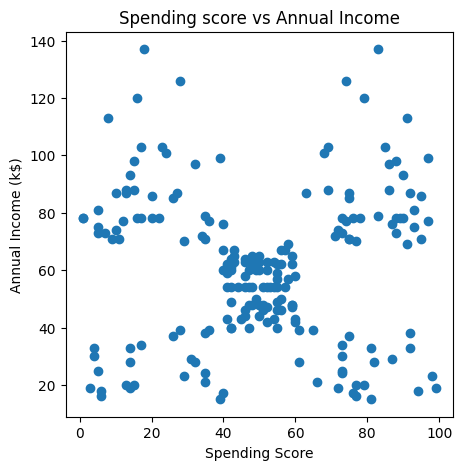

In [109]:
plt.figure(figsize=(5,5))
plt.scatter(x=df_pandas['Spending_Score(1-100)'],y=df_pandas["Annual_Income(k$)"])
plt.xlabel("Spending Score")
plt.ylabel("Annual Income (k$)")
plt.title("Spending score vs Annual Income")
plt.show

In [110]:
model_df = df.select('Annual_Income(k$)','Spending_Score(1-100)')

In [111]:
model_df.show()

+-----------------+---------------------+
|Annual_Income(k$)|Spending_Score(1-100)|
+-----------------+---------------------+
|               15|                   39|
|               15|                   81|
|               16|                    6|
|               16|                   77|
|               17|                   40|
|               17|                   76|
|               18|                    6|
|               18|                   94|
|               19|                    3|
|               19|                   72|
|               19|                   14|
|               19|                   99|
|               20|                   15|
|               20|                   77|
|               20|                   13|
|               20|                   79|
|               21|                   35|
|               21|                   66|
|               23|                   29|
|               23|                   98|
+-----------------+---------------

Vectorization and Scaling

In [112]:
from pyspark.ml.feature import StringIndexer, VectorAssembler
from pyspark.ml import Pipeline
from pyspark.ml.feature import StandardScaler ,MinMaxScaler

In [113]:
# features = ['Annual_Income(k$)', 'Spending_Score(1-100)']
features = model_df.columns
print(features)

['Annual_Income(k$)', 'Spending_Score(1-100)']


In [114]:
assembler = VectorAssembler(inputCols=features, outputCol="features")
model_df = assembler.transform(model_df)


In [115]:
# Standardize the features
scaler = StandardScaler(inputCol="features", outputCol="scaled_features", withStd=True, withMean=False)
model_df = scaler.fit(model_df).transform(model_df)

In [116]:
model_df.show()

+-----------------+---------------------+-----------+--------------------+
|Annual_Income(k$)|Spending_Score(1-100)|   features|     scaled_features|
+-----------------+---------------------+-----------+--------------------+
|               15|                   39|[15.0,39.0]|[0.57110829030364...|
|               15|                   81|[15.0,81.0]|[0.57110829030364...|
|               16|                    6| [16.0,6.0]|[0.60918217632388...|
|               16|                   77|[16.0,77.0]|[0.60918217632388...|
|               17|                   40|[17.0,40.0]|[0.64725606234413...|
|               17|                   76|[17.0,76.0]|[0.64725606234413...|
|               18|                    6| [18.0,6.0]|[0.68532994836437...|
|               18|                   94|[18.0,94.0]|[0.68532994836437...|
|               19|                    3| [19.0,3.0]|[0.72340383438461...|
|               19|                   72|[19.0,72.0]|[0.72340383438461...|
|               19|      

Replacing Scaled vectors with original features 

In [117]:
from pyspark.sql.functions import col

converting scaled_feature column vectors to array

In [118]:
from pyspark.ml.functions import vector_to_array
model_df = model_df.select('*', vector_to_array('scaled_features').alias('scaled_array_features'))
model_df.show()

+-----------------+---------------------+-----------+--------------------+---------------------+
|Annual_Income(k$)|Spending_Score(1-100)|   features|     scaled_features|scaled_array_features|
+-----------------+---------------------+-----------+--------------------+---------------------+
|               15|                   39|[15.0,39.0]|[0.57110829030364...| [0.57110829030364...|
|               15|                   81|[15.0,81.0]|[0.57110829030364...| [0.57110829030364...|
|               16|                    6| [16.0,6.0]|[0.60918217632388...| [0.60918217632388...|
|               16|                   77|[16.0,77.0]|[0.60918217632388...| [0.60918217632388...|
|               17|                   40|[17.0,40.0]|[0.64725606234413...| [0.64725606234413...|
|               17|                   76|[17.0,76.0]|[0.64725606234413...| [0.64725606234413...|
|               18|                    6| [18.0,6.0]|[0.68532994836437...| [0.68532994836437...|
|               18|           

In [119]:
# Extract values from 'scaled_features' column and create new columns
model_df = model_df.withColumn("Annual_Income(k$)", col("scaled_array_features")[0])
model_df = model_df.withColumn("Spending_Score(1-100)", col("scaled_array_features")[1])

# Drop the 'scaled_features' column
model_df = model_df.drop("scaled_array_features")

model_df.show()

+------------------+---------------------+-----------+--------------------+
| Annual_Income(k$)|Spending_Score(1-100)|   features|     scaled_features|
+------------------+---------------------+-----------+--------------------+
|0.5711082903036444|    1.510251022337088|[15.0,39.0]|[0.57110829030364...|
|0.5711082903036444|   3.1366752002385674|[15.0,81.0]|[0.57110829030364...|
|0.6091821763238874|   0.2323463111287828| [16.0,6.0]|[0.60918217632388...|
|0.6091821763238874|   2.9817776594860455|[16.0,77.0]|[0.60918217632388...|
|0.6472560623441304|   1.5489754075252185|[17.0,40.0]|[0.64725606234413...|
|0.6472560623441304|    2.943053274297915|[17.0,76.0]|[0.64725606234413...|
|0.6853299483643733|   0.2323463111287828| [18.0,6.0]|[0.68532994836437...|
|0.6853299483643733|   3.6400922076842637|[18.0,94.0]|[0.68532994836437...|
|0.7234038343846163|   0.1161731555643914| [19.0,3.0]|[0.72340383438461...|
|0.7234038343846163|   2.7881557335453935|[19.0,72.0]|[0.72340383438461...|
|0.723403834

converting feature vector column to Array

# Finding Best K using elbow point method

creating a list of sum of Squared error

In [120]:
k_rng = range(2,11)
sse=[] # sum of square error list
for k in k_rng:
    kmeans = KMeans(featuresCol="scaled_features").setK(k).setSeed(42)
    model = kmeans.fit(model_df)
    cost = model.summary.trainingCost
    sse.append(cost)
    
print(sse)

[269.3507453098518, 156.9154881096077, 122.27944728944352, 65.24056611493825, 55.10045942686508, 44.68662962224021, 41.4119899789239, 34.381097476329465, 36.098823013586056]


Plot the K value range vs SSE

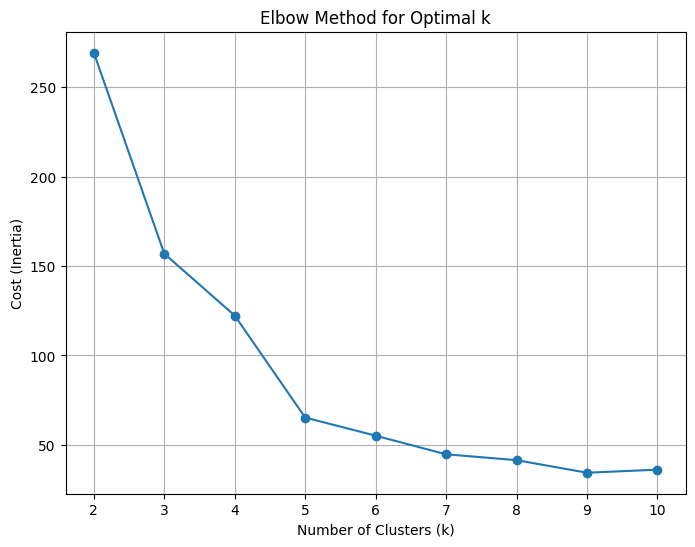

In [121]:
# Plot the cost vs. k to find the elbow point
plt.figure(figsize=(8, 6))
plt.plot(k_rng,sse, marker='o')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Cost (Inertia)')
plt.title('Elbow Method for Optimal k')
plt.xticks(k_rng)
plt.grid(True)
plt.show()

# Kmeans Model Training

In [122]:
kmeans = KMeans(featuresCol="scaled_features",k=5,seed=1) 
model = kmeans.fit(model_df)


In [123]:
# Make predictions
y_prediction = model.transform(model_df)
y_prediction.show()

+------------------+---------------------+-----------+--------------------+----------+
| Annual_Income(k$)|Spending_Score(1-100)|   features|     scaled_features|prediction|
+------------------+---------------------+-----------+--------------------+----------+
|0.5711082903036444|    1.510251022337088|[15.0,39.0]|[0.57110829030364...|         0|
|0.5711082903036444|   3.1366752002385674|[15.0,81.0]|[0.57110829030364...|         2|
|0.6091821763238874|   0.2323463111287828| [16.0,6.0]|[0.60918217632388...|         0|
|0.6091821763238874|   2.9817776594860455|[16.0,77.0]|[0.60918217632388...|         2|
|0.6472560623441304|   1.5489754075252185|[17.0,40.0]|[0.64725606234413...|         0|
|0.6472560623441304|    2.943053274297915|[17.0,76.0]|[0.64725606234413...|         2|
|0.6853299483643733|   0.2323463111287828| [18.0,6.0]|[0.68532994836437...|         0|
|0.6853299483643733|   3.6400922076842637|[18.0,94.0]|[0.68532994836437...|         2|
|0.7234038343846163|   0.1161731555643914| 

cluster count

In [124]:
y_prediction.groupBy("prediction").count().show()

+----------+-----+
|prediction|count|
+----------+-----+
|         1|   39|
|         3|   81|
|         4|   35|
|         2|   22|
|         0|   23|
+----------+-----+



finding Centers of custers 

In [125]:
cluster_centers = model.clusterCenters()
print("==Centers==")
for center in cluster_centers:
    print(center)

==Centers==
[1.00150874 0.80984475]
[3.29485552 3.18036425]
[0.97953725 3.07330802]
[2.10534488 1.91757419]
[3.35811675 0.66274019]


Convert spark to pandas for plotting

In [126]:
y_pandas = y_prediction.toPandas()


In [127]:
y_pandas

,Annual_Income(k$),Spending_Score(1-100),features,scaled_features,prediction
0,0.571108,1.510251,"[15.0, 39.0]","[0.5711082903036444, 1.510251022337088]",0
1,0.571108,3.136675,"[15.0, 81.0]","[0.5711082903036444, 3.1366752002385674]",2
2,0.609182,0.232346,"[16.0, 6.0]","[0.6091821763238874, 0.2323463111287828]",0
3,0.609182,2.981778,"[16.0, 77.0]","[0.6091821763238874, 2.9817776594860455]",2
4,0.647256,1.548975,"[17.0, 40.0]","[0.6472560623441304, 1.5489754075252185]",0
...,...,...,...,...,...
195,4.568866,3.059226,"[120.0, 79.0]","[4.568866322429155, 3.0592264298623064]",1
196,4.797310,1.084283,"[126.0, 28.0]","[4.7973096385506135, 1.0842827852676529]",4
197,4.797310,2.865605,"[126.0, 74.0]","[4.7973096385506135, 2.8656045039216544]",1
198,5.216122,0.697039,"[137.0, 18.0]","[5.216122384773286, 0.6970389333863484]",4


Plotting scatter plot Annual income vs spending score with clusters

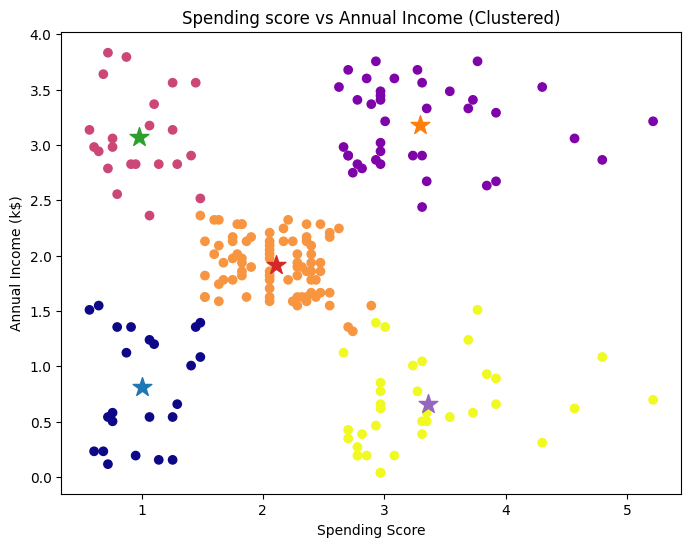

In [128]:
plt.figure(figsize=(8, 6))
plt.scatter(x=y_pandas['Annual_Income(k$)'], y=y_pandas['Spending_Score(1-100)'],c=y_pandas['prediction'],cmap='plasma')
plt.xlabel("Spending Score")
plt.ylabel("Annual Income (k$)")
plt.title("Spending score vs Annual Income (Clustered)")
# Plot cluster center
for i,center in enumerate(cluster_centers):
    plt.scatter(x=center[0],y=center[1],marker='*',s=200,label=f"centroid {i+1}")
plt.show()

# Performance Metrices

Silhoutte Score

In [129]:
from pyspark.ml.evaluation import ClusteringEvaluator

In [130]:
eval = ClusteringEvaluator()

In [131]:
silhouette = eval.evaluate(y_prediction)
print(f"Silhouetter Score:{silhouette}")

Silhouetter Score:0.7397829244623759


Stop Spark session

In [132]:
spark.stop()